In [8]:
import numpy as np
from numpy.linalg import eig
import numpy.linalg as LA
import networkx as nx
from scipy.linalg import solve
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import math

# Plotting defaults
plt.rcParams['figure.dpi'] = 100

In [9]:
def multiple_ring_setup(L, m):
    '''
    Setup an adjacency matrix A for the 3 undirected nearest-neighbor 
    graphs with shortcut. All 3 rings are connected by one central node. 
    Inputs:
    - L: shortcut end node < m.
    - m: number of nodes per ring.
    Outputs:
    - A: adjacency matrix.
    - D: degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    - pos: dictionary containing the positions of the nodes.
    '''
    N = m * 3 + 1
    A = np.zeros((N, N))
    A_sq = np.matmul(A, A)
    
    D = 2 * np.eye(N)
    D[-1, -1] = 3
    
    for j in range(int(np.floor(N/m))):
        for i in range(j*m, (j+1)*m-1):
            A[i, i+1] = 1
            A[i+1, i] = 1
        A[j*m, L-1+j*m] = 1
        A[j*m, (j+1)*m-1] = 1
        A[(j+1)*m-1, j*m] = 1
        
    
        A[N-1, j*m] = 1
        A[j*m, N-1] = 1
        
        D[j*m, j*m] = 3
    S = np.copy(A)
    for j in range(int(np.floor(N/m))):
        S[j*m, L-1+j*m] = 0
      
    # Setup for the positioning of the graph nodes
    pos = {}
    for i in range(int(np.floor(N/m))):
        for x in range(m):
            if i == 0:
                pos[i*m+x] = (-1 - math.acos(math.pi/5) + math.cos(math.pi/5*x - math.pi/5),
                           1 + math.asin(math.pi/5) + math.sin(math.pi/5*x - math.pi/5))
            if i == 1:
                pos[i*m+x] = (1 + math.acos(math.pi/5) + math.cos(math.pi/5*x - 4*math.pi/5),
                          1 + math.asin(math.pi/5) + math.sin(math.pi/5*x - 4*math.pi/5))
            if i == 2:
                pos[i*m+x] = (math.cos(math.pi/5*x+math.pi/2),
                                    -2+math.sin(2*math.pi/10*x+math.pi/2))

    pos[N-1] = (0,  0)

    return A, D, S, pos


def spec_rad(A):
    '''
    Calculates the spectral radius of adjacency matrix A.
    Input:
    - A: adjacency matrix.
    Output:
    - spectral radius of matrix A.
    '''
    eigs = eig(A)[0]
    return max(abs(eigs))

def Katz(alpha, A, L=None, normed=False, approx=False):
    '''
    Calculates Katz centrality of a graph with adjacency matrix A
    and parameters t1, t2, h1 and h2 contained in the approximation
    of Katz centrality on the undirected nearest-neighbor graph 
    with shortcut.
    Inputs:
    - alpha: downweighting parameter.
    - A: adjacency matrix.
    - L: long range shortcut index, only necessary when appproximation
    parameters are requested
    - normed: boolean indicating whether the output should be normed,
    default: False.
    - approx: boolean indicating whether the approximation parameters
    for the modified ring are requested, default: False.
    Outputs:
    - centrality: Katz centrality.
    - t1 (optional): root 1.
    - t2 (optional): root 2.
    - h1 (optional): constant > 0.
    - h2 (optional): constant > 0.
    '''
    N = len(A)
    Aa = np.eye(N) - alpha*A
    rhs = np.ones(N)
    centrality = solve(Aa, rhs)
    if normed == True:
        centrality /= LA.norm(centrality, 1) 
    
    if approx==True:
     
        # Roots
        t1 = (1 - np.sqrt(1 - 4*alpha**2)) / (2*alpha)
        t2 = (1 + np.sqrt(1 - 4*alpha**2)) / (2*alpha)
    
        # solve 2x2 system to find h1 and h2
        left = np.array([[1 - 2*alpha*t1 - alpha*t1**(L-1), 1 - 2*alpha*t2 - alpha*t2**(L-1)],
                     [t1**(N/2-1) * (t1-2*alpha), t2**(N/2-1) * (t2-2*alpha)]])
        right = np.array([alpha / (1 - 2*alpha), 0])
    
        h = solve(left, right)
        h1 = float(h[0])
        h2 = float(h[1])

        return centrality, t1, t2, h1, h2
    else:
        return centrality

def NBTW_spec_rad(A, D, S):
    '''
    Calculates the spectral radius of the companion linearization
    of the reversal matrix polynomial of matrix polynomial 
    M(t) = I - At + (D-I)t^2 + (A-S)t^3. Named: C.
    Input:
    - A: adjacency matrix.
    - D: degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    Output:
    - spectral radius of matrix C.
    '''
    N = len(A)
    # Create matrix C
    C = np.zeros((3*N, 3*N))
    C[0: N, 0: N] = A
    C[0: N, N: 2*N] = np.eye(N) - D
    C[0: N, 2*N: 3*N] = S - A
    C[N: 2*N, 0: N] = np.eye(N)
    C[2*N: 3*N, N: 2*N] = np.eye(N)
    
    eigs = eig(C)[0]
    return max(abs(eigs))

def NBTW(alpha, A, D, S, L=None, normed=False, approx=False):
    '''
    Calculates NBTW centrality of a graph with adjacency matrix A
    and parameters t1, t2, h1 and h2 contained in the approximation
    of NBTW centrality on the undirected nearest-neighbor graph 
    with shortcut.
    Inputs:
    - alpha: downweighting parameter.
    - A: adjacency matrix.
    - D: diagonal degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    - L: long range shortcut index, only necessary when appproximation
    parameters are requested
    - normed: boolean indicating whether the output should be normed,
    default: False.
    - approx: boolean indicating whether or not the approximation 
    parameters for the modified ring are requested, default: False.
    Outputs:
    - NBTWcentrality: NBTW centrality
    - t1 (optional): root 1.
    - t2 (optional): root 2.
    - h1 (optional): constant > 0.
    - h2 (optional): constant > 0.
    '''
    N = len(A)
    
    # deformed graph Laplacian:
    M = np.eye(N) - A*alpha + (D-np.eye(N))*alpha**2  + (A-S)*alpha**3 
    
    rhs = (1-alpha**2) * np.ones(N)
    NBTWcentrality = solve(M, rhs)
    if normed == True:
        NBTWcentrality /= LA.norm(NBTWcentrality, 1) 
    
    if approx==True:
        # Roots
        t1 = alpha
        t2 = 1 / alpha
    
        # solve 2x2 system to find h1 and h2
        left = np.array([[-alpha**2 + 1 + (alpha**2-1)*alpha**L, -1 + alpha**2 + (alpha**2-1)*alpha**(2-L)], 
                     [(alpha**2 - 1) * alpha**(N/2), -2*alpha**(2 - N/2) + (1 + alpha**2)*alpha**(-N/2)]])
        right = np.array([[alpha * (alpha+1)**2], [0]])
    
        h = solve(left, right)
        h1 = float(h[0])
        h2 = float(h[1])

        return NBTWcentrality, t1, t2, h1, h2
    else:
        return NBTWcentrality

def create_graph(A, nodesize, node_color, pos=None, circular=True):
    '''
    Plots the graph associated with adjacency matrix A. 
    Inputs:
    - A: adjacency matrix
    - nodesize: list indicating the sizes of the nodes,
    typically the centrality vector.
    - node_color: list indicating the color for each node,
    typically the centrality vector.
    - pos: dictionary containing the positions of the 
    nodes. Only necessary when not dealing with a circular
    graph.
    - circular: boolean indicating whether or not a circular
    graph is required, default: True
    '''
    N = len(A)
    
    G = nx.from_numpy_matrix(A, create_using=nx.MultiDiGraph)
    labeldict = {}
    for i in range(N):
        labeldict[i] = i+1
        
    if circular == True:
        nx.draw_circular(G, 
                         labels=labeldict, 
                         node_size=nodesize, 
                         node_color=node_color,
                         font_color='white')
    else:
        nx.draw(G, 
                labels=labeldict, 
                node_size=nodesize, 
                node_color=node_color,
                font_color='white',
                pos=pos)   

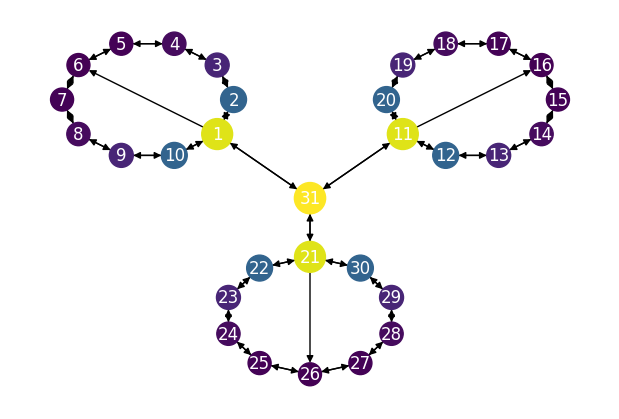

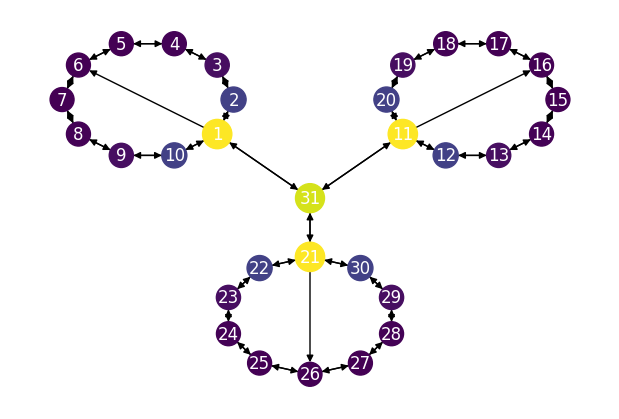

node 1: 0.04939633373381781 node N 0.0505262665033019


In [11]:
# Initialisation
L = 6
m = 10
N = 31
# --- Create the matrices and draw network
A, D, S, pos = multiple_ring_setup(L, m)

### NBTW centrality

# take 60.9% of upper limit
t = 0.45 / NBTW_spec_rad(A, D, S)
# or take a specific t
#t = 0.75

x = NBTW(t, A, D, S, normed=True)

create_graph(A, x*10000, x, pos=pos, circular=False)
#plt.title('NBTW')
plt.savefig('MultipleNBTWgraph.pdf')
plt.show()

### Katz centrality

a = 0.45/spec_rad(A)

x2 = Katz(a, A, normed=True)
create_graph(A, x2*10000, x2, pos=pos, circular=False)
#plt.title('Katz')
plt.savefig('multipleKatzgraph.pdf')
plt.show()

print('node 1:', x[0], 'node N', x[-1])

### Checking whether the calculations are correct

0.4070999999999998 0.4070999999999998 0.4071
-147.34295466 30.54344704 theory and estimate are close-ish for x1
-117.27971539 25.28845422 theory and estimate are close-ish for x2
-70.50597353 7.69565217 theory and estimate are close-ish for xL


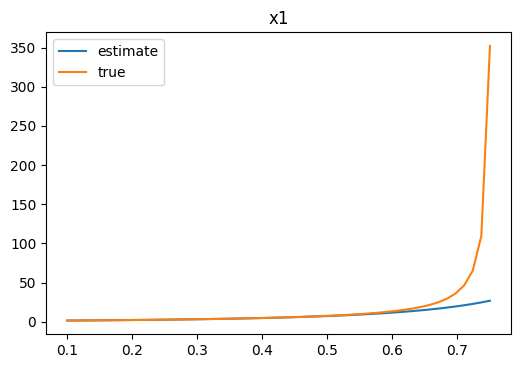

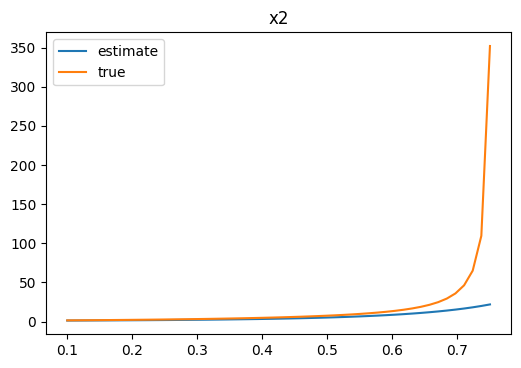

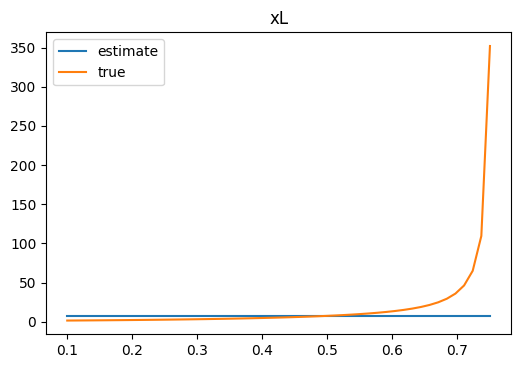

at t = 0.28 the centrality of N becomes bigger


In [18]:
m = 10
N = 31
L = 6

A, D, S, pos = multiple_ring_setup(L, m)
t = 0.77
a = 0.77

b2 = (1 + a) / (1 - a)
h = (-2 * a * (a * (a+1)**2 + 1)) / (a - 1)

x1 = b2 + h
x2 = b2 + h * t
xm = x2
xL = b2
xN = (1-a**2+3*a*x1)/(1+2*a**2)

left1 = (-a)*(xm+x2+xN)+(-a+a**3)*xL+(1+2*a**2)*x1
right = 1-a**2
left2 = (1+2*a**2)*xN - 3*a*x1
print(left1, left2, right)
x = NBTW(t, A, D, S)
print(round(x[0],8), round(x1, 8), 'theory and estimate are close-ish for x1')
print(round(x[1],8), round(x2, 8),'theory and estimate are close-ish for x2')
print(round(x[L-1], 8), round(xL, 8),'theory and estimate are close-ish for xL')

x1s = []
xs = []
for a in np.linspace(0.1, 0.75, 50):
    b2 = (1 + a) / (1 - a)
    h = (-2 * a * (a * (a+1)**2 + 1)) / (a - 1)
    x1 = b2 + h
    x1s.append(x1)
    x = NBTW(a, A, D, S)
    xs.append(x[0])
plt.plot(np.linspace(0.1, 0.75, 50), x1s, label = 'estimate')
plt.plot(np.linspace(0.1, 0.75, 50), xs, label='true')
plt.legend()
plt.title('x1')
plt.show()

x2s = []
xs = []
for a in np.linspace(0.1, 0.75, 50):
    b2 = (1 + a) / (1 - a)
    h = (-2 * a * (a * (a+1)**2 + 1)) / (a - 1)
    x2 = b2 + h*a
    x2s.append(x2)
    x = NBTW(a, A, D, S)
    xs.append(x[0])
plt.plot(np.linspace(0.1, 0.75, 50), x2s, label = 'estimate')
plt.plot(np.linspace(0.1, 0.75, 50), xs, label='true')
plt.legend()
plt.title('x2')
plt.show()

xLs = []
xs = []
for a in np.linspace(0.1, 0.75, 50):
    b2 = (1 + a) / (1 - a)
    h = (-2 * a * (a * (a+1)**2 + 1)) / (a - 1)
    x2 = b2 + h*a
    xLs.append(xL)
    x = NBTW(a, A, D, S)
    xs.append(x[0])
plt.plot(np.linspace(0.1, 0.75, 50), xLs, label = 'estimate')
plt.plot(np.linspace(0.1, 0.75, 50), xs, label='true')
plt.legend()
plt.title('xL')
plt.show()

t = 0.0001
x[-1] = 0
x[0] = 1
while (x[-1] < x[0]):  # N<1
    x = NBTW(t, A, D, S,  normed=True)
    t+= 0.00001
    if t>1:
        break
print('at t =', np.round(t, 2), 'the centrality of N becomes bigger')

### Check ansatz NBTW

alpha is 0.3


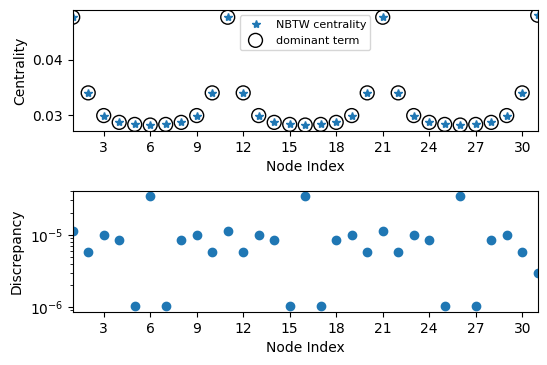

In [20]:
m = 10
N = 31
L = 6
A, D, S, pos = multiple_ring_setup(L, m)

bound = NBTW_spec_rad(A, D, S)
#a = 0.9 / bound
a = 0.3
s = 0.3
print('alpha is', a)

b2 = (1 + a) / (1 - a)
h = (-2 * a * (a * (a+1)**2 + 1)) / (a - 1)


# set up the estimation vector
est = np.zeros(N)
for j in range(int(np.floor(N/m))):
    for i in range(2,m-1):
            if i == L-1:
                est[j*m+i] = b2
            pi = min(i, m-i)
            est[j*m+i] = b2 + h * a**(pi)
    est[j*m] = b2+h
    est[j*m+1] = b2+h*a
    est[j*m+9] = b2+h*a

est[-1] = (1-a**2+3*a*est[0])/(1+2*a**2)

est /= np.linalg.norm(est,1)
#true centrality
x = NBTW(a, A, D, S, normed=True)

#plot result
fig, (ax1, ax2) = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.5)     # add horizontal space between plots

ax1.scatter(range(1, N+1), est,
            facecolors='none', 
            edgecolors='black',  
            s=100, 
            label = 'dominant term')
ax1.plot(range(1, N+1), x, '*', label='NBTW centrality')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlim([1,31])
ax1.set_xlabel('Node Index')
ax1.set_ylabel('Centrality')
ax1.legend(prop={'size': 8})

#--- Plot discrepancy
difference = [abs(x[i] - est[i]) for i in range(N)]
#print(*difference, sep = "\n") 

plt.plot(range(1, N+1), difference, 'o')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlim([1, N])
ax2.set_yscale('log')
plt.xlabel('Node Index')
plt.ylabel('Discrepancy')
plt.savefig('multipleringsdiscrepancy.pdf')
plt.show()

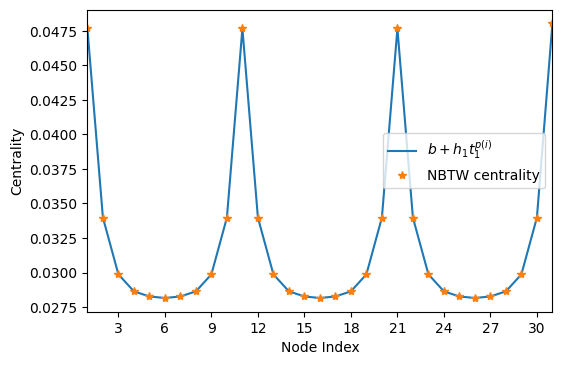

In [21]:
fig, ax = plt.subplots()
plt.plot(range(1, N+1), est, label = r'$b+h_1t_1^{p(i)}$')
plt.plot(range(1, N+1), x, '*', label='NBTW centrality')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlim([1, 31])
plt.xlabel('Node Index')
plt.ylabel('Centrality')
plt.legend()
plt.savefig('multipleNBTW90.pdf')
plt.show()

### Checking Katz

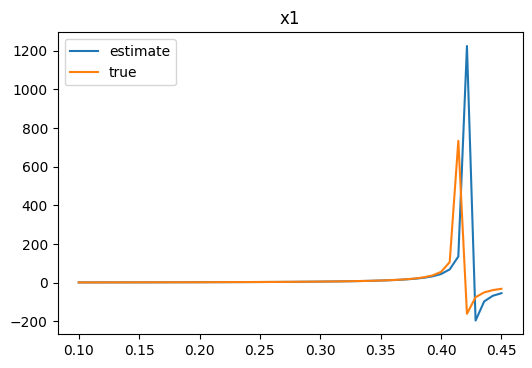

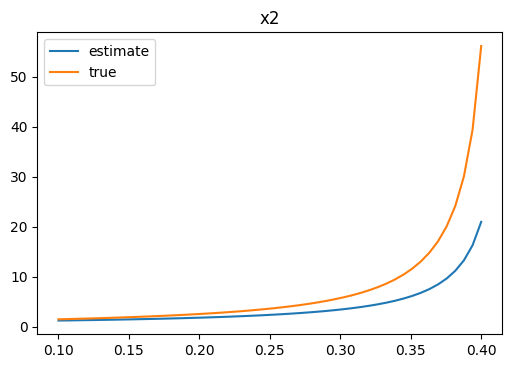

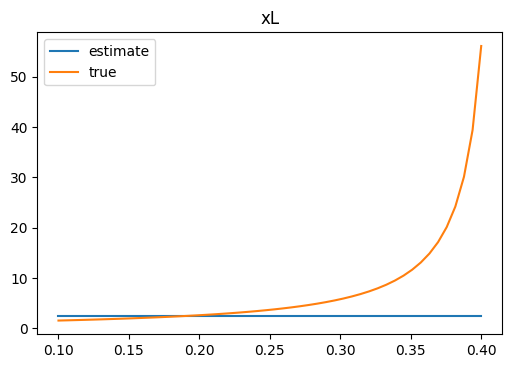

at t = 0.22 the centrality of N becomes bigger


In [28]:
m = 10
N = 31
L = 6
A, D, S, pos = multiple_ring_setup(L, m)
a = 0.3
t1 = (1-np.sqrt(1-4*a**2))/ (2*a)

b2 = 1/(1-2*a)
h = (a*(2+a))/((1-2*a)*(1-2*a*t1-3*a**2))

x1 = b2 + h
x2 = b2 + h * t1
xm = x2
xL = b2
xN = 1-3*a*x1

x = Katz(a, A)
# print(round(x[0],8), round(x1, 8), 'theory and estimate are close-ish for x1')
# print(round(x[1],8), round(x2, 8),'theory and estimate are close-ish for x2')
# print(round(x[L-1], 8), round(xL, 8),'theory and estimate are close-ish for xL')


x1s = []
xs = []
for a in np.linspace(0.1, 0.45, 50):
    b2 = 1/(1-2*a)
    t1 = (1-np.sqrt(1-4*a**2))/ (2*a)
    h = (a*(2+a))/((1-2*a)*(1-2*a*t1-3*a**2))
    x1 = b2 + h
    x1s.append(x1)
    x = Katz(a, A)
    xs.append(x[0])

plt.plot(np.linspace(0.1, 0.45, 50), x1s, label = 'estimate')
plt.plot(np.linspace(0.1, 0.45, 50), xs, label='true')
plt.legend()
plt.title('x1')
plt.show()

x2s = []
xs = []
for a in np.linspace(0.1, 0.4, 50):
    b2 = 1/(1-2*a)
    t1 = (1-np.sqrt(1-4*a**2))/ (2*a)
    h = (a*(2+a))/((1-2*a)*(1-2*a*t1-3*a**2))
    x2 = b2 + h*a
    x2s.append(x2)
    x = Katz(a, A)
    xs.append(x[0])
plt.plot(np.linspace(0.1, 0.4, 50), x2s, label = 'estimate')
plt.plot(np.linspace(0.1, 0.4, 50), xs, label='true')
plt.legend()
plt.title('x2')
plt.show()

xLs = []
xs = []
for a in np.linspace(0.1, 0.4, 50):
    b2 = 1/(1-2*a)
    t1 = (1-np.sqrt(1-4*a**2))/ (2*a)
    h = (a*(2+a))/((1-2*a)*(1-2*a*t1-3*a**2))
    x2 = b2 + h*a
    xLs.append(xL)
    x = Katz(a, A)
    xs.append(x[0])
plt.plot(np.linspace(0.1, 0.4, 50), xLs, label = 'estimate')
plt.plot(np.linspace(0.1, 0.4, 50), xs, label='true')
plt.legend()
plt.title('xL')
plt.show()


a = 0.0001
x[-1] = 0
x[0] = 1
while (x[-1] < x[0]):  # N<1
    x = Katz(a, A)
    a+= 0.00001
    if a>0.5:
        break
print('at t =', np.round(a, 2), 'the centrality of N becomes bigger')

0.3739856459321249


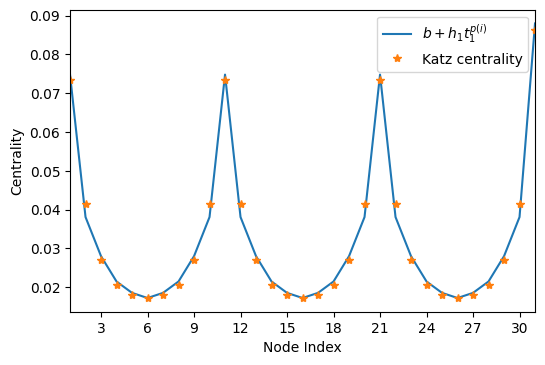

In [27]:
# check ansatz b+ht^pi
m = 10
N = 31
L = 6
A, D, S, pos = multiple_ring_setup(L, m)
bound = spec_rad(A)
a = 0.4
a = 0.9/bound
print(a)
t1 = (1-np.sqrt(1-4*a**2))/ (2*a)
b2 = 1/(1-2*a)
h = (a*(2+a))/((1-2*a)*(1-2*a*t1-3*a**2))

# set up the estimation vector
est = np.zeros(N)
for j in range(int(np.floor(N/m))):
    for i in range(2,m-1):
            if i == L-1:
                est[j*m+i] = b2
            pi = min(i, m-i)
            est[j*m+i] = b2 + h * t1**(pi)
    est[j*m] = b2+h
    est[j*m+1] = b2+h*a
    est[j*m+9] = b2+h*a

est[-1] = 1+3*a*est[0]

est /= np.linalg.norm(est, 1)
#true centrality
x = Katz(a, A, normed=True)

fig, ax = plt.subplots()
plt.plot(range(1, N+1), est, label = r'$b+h_1t_1^{p(i)}$')
plt.plot(range(1, N+1), x, '*', label='Katz centrality')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlim([1, 31])
plt.xlabel('Node Index')
plt.ylabel('Centrality')
plt.legend()
plt.savefig('multipleKatz90.pdf')
plt.show()

### Plotting $x_1/x_N$ as $\alpha$ is varied

done


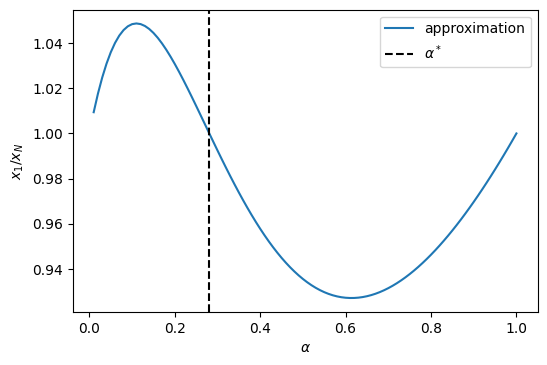

In [29]:
m = 100
N = 301
L = 60
A, D, S, pos = multiple_ring_setup(L, m)
print('done')

direct = []
ratio = []
arange = np.linspace(0.01, 0.999999999999, 100)
for a in arange:
    # --- estimate
    b2 = (1 + a)/ (1 - a)
    h = (-2 * a * (a * (a+1)**2 + 1)) / (a - 1)
    x1 = b2+h
    xN = (1-a**2+3*a*x1)/(1+2*a**2)
    ratio.append(x1/xN)
    # --- direct calculation
    b = np.ones(N)
    M = np.eye(N) - A * a + (D - np.eye(N)) * a**2  + (A - S) * a**3 # deformed graph Laplacian
    rhs = (1 - a**2) * b
    res = solve(M, rhs)
    direct.append(res[0] / res[-1])
plt.plot(arange, ratio, label = 'approximation')
#plt.plot(arange, direct)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$x_1/x_N$')
plt.axvline(x=0.280776, linestyle='--', label = r'$\alpha^*$', color = 'black')
plt.legend()
plt.savefig('ratio.pdf')
plt.show()
# difference = [direct[i] - ratio[i] for i in range(50)]
# fig, ax = plt.subplots()
# ax.set_yscale('log')
# plt.plot(difference, 'o')
# plt.show()

In [34]:
print('bound on a for Katz: ', np.round(1/spec_rad(A), 4))
print('bound on a for NBTW: ', np.round(1/NBTW_spec_rad(A,D,S), 4))

bound on a for Katz:  0.4224
bound on a for NBTW:  0.9631
